In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
from transformers import SwinForImageClassification
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.metrics import precision_score, f1_score
import time
import random


In [2]:
# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Images before preprocessing:


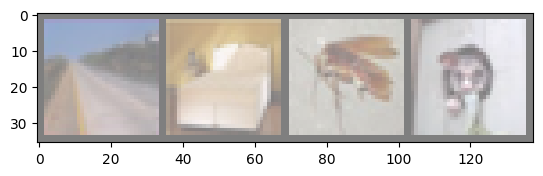

In [3]:
# Function to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Load the CIFAR-100 dataset
dataset = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Show images before preprocessing
dataiter = iter(DataLoader(dataset, batch_size=4, shuffle=True))
images, labels = next(dataiter)
print("Images before preprocessing:")
imshow(torchvision.utils.make_grid(images))  # Display raw images


Files already downloaded and verified


Images after preprocessing:


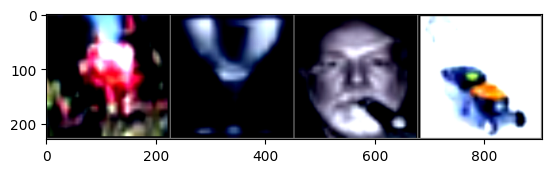

In [4]:
# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing and visualize after transformations
preprocessed_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
dataiter = iter(DataLoader(preprocessed_dataset, batch_size=4, shuffle=True))
preprocessed_images, labels = next(dataiter)
print("Images after preprocessing:")
imshow(torchvision.utils.make_grid(preprocessed_images))

In [5]:
# Split the dataset for training and testing
train_size = int(0.8 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size
train_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Selected hyperparameters - Learning rate: 0.0001, Batch size: 64, Epochs: 6
Epoch [1/6], Training Loss: 1.3021
Epoch [1], Validation Loss: 0.6726, Accuracy: 79.41%, Precision: 0.8046, F1 Score: 0.7902
Epoch [2/6], Training Loss: 0.5953
Epoch [2], Validation Loss: 0.6419, Accuracy: 80.44%, Precision: 0.8160, F1 Score: 0.8016
Epoch [3/6], Training Loss: 0.4200
Epoch [3], Validation Loss: 0.5558, Accuracy: 83.74%, Precision: 0.8410, F1 Score: 0.8353
Epoch [4/6], Training Loss: 0.3258
Epoch [4], Validation Loss: 0.5979, Accuracy: 82.77%, Precision: 0.8341, F1 Score: 0.8247
Epoch [5/6], Training Loss: 0.2611
Epoch [5], Validation Loss: 0.6234, Accuracy: 82.97%, Precision: 0.8365, F1 Score: 0.8281
Epoch [6/6], Training Loss: 0.2086
Epoch [6], Validation Loss: 0.6047, Accuracy: 83.91%, Precision: 0.8438, F1 Score: 0.8359


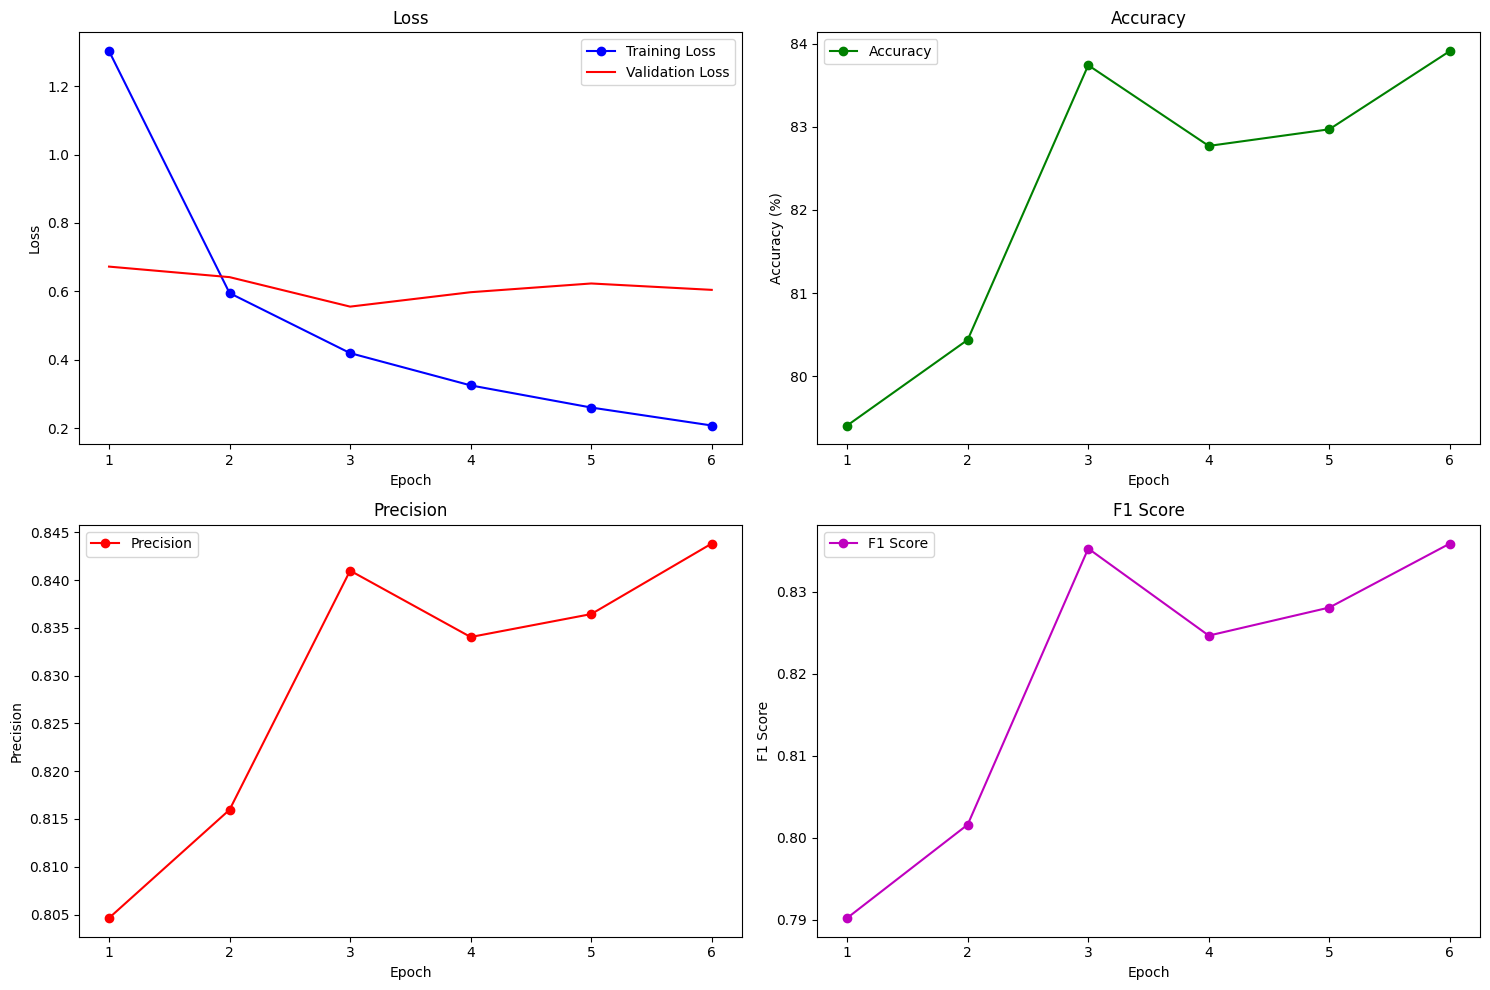

In [6]:
# Define the model
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=100,
    ignore_mismatched_sizes=True
)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Hyperparameter tuning using random search
learning_rates = [1e-5, 1e-4, 5e-4]
batch_sizes = [16, 32, 64]
num_epochs_list = [4, 6, 8]

# Randomly select hyperparameters
random_lr = random.choice(learning_rates)
random_batch_size = random.choice(batch_sizes)
random_num_epochs = random.choice(num_epochs_list)
print(f"Selected hyperparameters - Learning rate: {random_lr}, Batch size: {random_batch_size}, Epochs: {random_num_epochs}")

optimizer = optim.Adam(model.parameters(), lr=random_lr)
train_loader = DataLoader(train_dataset, batch_size=random_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=random_batch_size, shuffle=False)

# Initialize arrays to store loss and accuracy values
train_losses = []
val_losses = []
test_accuracies = []
precisions = []
f1_scores = []

# Early stopping parameters
patience = 3
best_accuracy = 0.0
epochs_no_improve = 0
early_stop = False

# Training loop
start_time = time.time()
for epoch in range(random_num_epochs):
    if early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("Loss is NaN or Inf!")
            continue

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{random_num_epochs}], Training Loss: {train_losses[-1]:.4f}')

    # Validation/Test Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_losses.append(val_loss / len(test_loader))
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    precision = precision_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    precisions.append(precision)
    f1_scores.append(f1)

    print(f'Epoch [{epoch+1}], Validation Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, F1 Score: {f1:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        early_stop = True

# Plot loss, accuracy, precision, and F1 score
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 10))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, 'go-', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precisions, 'ro-', label='Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot F1 score
plt.subplot(2, 2, 4)
plt.plot(epochs, f1_scores, 'mo-', label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()